In [215]:
# Print stuff inline
%matplotlib inline

# Imports
import re
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
from IPython.display import display
from sklearn. model_selection import cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix, f1_score)
from sklearn.naive_bayes import MultinomialNB
from wordcloud import STOPWORDS, WordCloud

In [216]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer


# Load the data 

In [175]:
data = pd.read_csv("flipkart1.csv")

In [212]:
data.head()

,Unnamed: 0,Review,Rating
0,0,sweet thing note buy mostli game make sure cho...,5
1,1,worth cost happi time deliveri wish would glos...,5
2,2,good,5
3,3,go,5
4,4,monitor good deliveri proper 2 month run witho...,4


In [213]:
#delete unwanted column
del data['Unnamed: 0']

In [217]:
data.head()

,Review,Rating
0,sweet thing note buy mostli game make sure cho...,5
1,worth cost happi time deliveri wish would glos...,5
2,good,5
3,go,5
4,monitor good deliveri proper 2 month run witho...,4


# Clean the data 

In [160]:
#!pip install spacy==2.2.3


In [161]:
#!pip install beautifulsoup4==4.9.1


In [162]:
#!pip install textblob==0.15.3

In [176]:
data.head()

,Unnamed: 0,Review,Rating
0,0,Sweet ! Few things to note if you are buying i...,5
1,1,Worth the cost and happy with the timely deliv...,5
2,2,Good,5
3,3,Go for it...,5
4,4,"Monitor is good, delivery was proper, it has b...",4


In [218]:
def remove_html(text):
    soup=BeautifulSoup(text,'lxml')
    html_free=soup.get_text()
    return html_free

In [219]:
#To remove punctuation
def remove_punctuation(text):
    no_punct="".join([c for c in text if c not in string.punctuation])
    return no_punct

In [220]:
import string
data['Review']=data['Review'].apply(lambda x:remove_punctuation(x))

In [221]:
data['Review'].head()

0    sweet thing note buy mostli game make sure cho...
1    worth cost happi time deliveri wish would glos...
2                                                 good
3                                                   go
4    monitor good deliveri proper 2 month run witho...
Name: Review, dtype: object

Tokenize

In [222]:
tokenizer=RegexpTokenizer(r'\w+')

In [223]:
data['Review']=data['Review'].apply(lambda x:tokenizer.tokenize(x.lower()))

REMOVE STOPWORDS

In [224]:
def remove_stopwords(text):
    words=[w for w in text if w not in stopwords.words('english')]
    return words

In [171]:
#nltk.download('stopwords')

In [225]:
data['Review']=data['Review'].apply(lambda x : remove_stopwords(x))

Stemming and lemmatizing

In [226]:
lemmatizer=WordNetLemmatizer()
def word_lemmatizer(text):
    lem_text=[lemmatizer.lemmatize(i) for i in text]
    return lem_text

In [227]:
#nltk.download('wordnet')

In [228]:
data['Review']=data['Review'].apply(lambda x : word_lemmatizer(x))

Stemmer

In [229]:
#Instantiate stemmer

stemmer=PorterStemmer()


In [230]:
def word_stemmer(text):
    stem_text=" ".join([stemmer.stem(i) for i in text])
    return stem_text

In [231]:
data['Review']=data['Review'].apply(lambda x : word_stemmer(x))

In [232]:
# Sometimes people leave ratings without reviews. We are going to ignore empty reviews.
data = data[data['Review'].isnull()==False]

# Get the ratings column.
ratings = data['Rating']



Rounding off the ratings to make sure they are in numbers 1,2,3,4,5

In [233]:
data['Rating']=data['Rating'].replace('-',2)

In [234]:
data['Rating']=data['Rating'].astype(float)

In [235]:
def round_school(x):
    i,f=divmod(x,1)
    return int(i +((f >=0.5)if (x >0)else(f> 0.5)))

In [236]:
data['Rating']=data['Rating'].apply(lambda x : round_school(x))

In [237]:
data['Rating'].value_counts()

5    19558
4     8629
1     4551
3     3050
2     2457
Name: Rating, dtype: int64

# Explore the data

Text(0, 0.5, 'Count')

<Figure size 1440x1080 with 0 Axes>

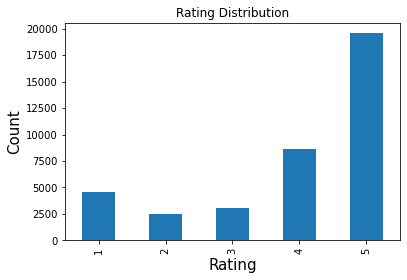

In [238]:
# Create and print a rating distribution graph.
plt.figure(figsize = (20, 15))
rating_distribution_plt = data.groupby(['Rating']).count().plot(kind='bar', legend=None, title="Rating Distribution")
rating_distribution_plt.set_xlabel("Rating",fontsize=15)
rating_distribution_plt.set_ylabel("Count",fontsize=15)

Text(0, 0.5, 'Count')

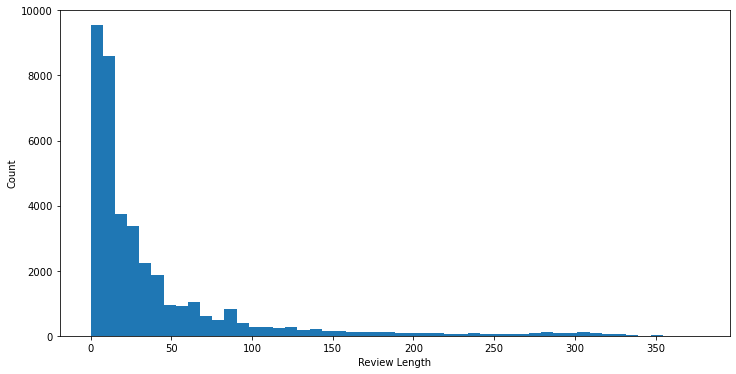

In [239]:
# Create and print a Reviews length distribution graph.
review_length_distribution_plt = pd.DataFrame(data["Review"].str.len())
review_length_distribution_plt = review_length_distribution_plt[review_length_distribution_plt.Review < 5000]
review_length_distribution_plt.groupby(["Review"])
review_length_distribution_plt = review_length_distribution_plt.plot(kind='hist', 
                                                                     legend=None, 
                                                                     bins=50, 
                                                                     figsize=(12, 6))
review_length_distribution_plt.set_xlabel("Review Length")
review_length_distribution_plt.set_ylabel("Count")


# TF-IDF VECTORIZER

In [298]:

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report

In [299]:
tfidf = TfidfVectorizer(max_features=20000, ngram_range=(1,5), analyzer='char')

In [300]:
X = tfidf.fit_transform(data['Review'])
y = df['Rating']

In [301]:
 y=y.astype('int')

In [302]:
X.shape, y.shape

((38245, 20000), (38245,))

# Train/Test Split

In [303]:
from sklearn.model_selection import train_test_split

In [304]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [305]:
X_train.shape

(30596, 20000)

# Benchmark model 
For the benchmark, we are not going to do any parameter tuning; we are going to use sklearns default parameters. As we will see, logistic regression does fairly well right out of the box.

In [309]:
clf_benchmark = LogisticRegression(random_state=22).fit(X_train, y_train)
print( classification_report(y_test, clf_benchmark.predict(X_test), digits=4))

              precision    recall  f1-score   support

           0     0.8185    1.0000    0.9002       212
           1     0.7053    0.7866    0.7438       928
           2     0.2000    0.0181    0.0332       276
           3     0.4961    0.1881    0.2728       675
           4     0.7121    0.2962    0.4183      1587
           5     0.6958    0.9486    0.8028      3971

    accuracy                         0.6943      7649
   macro avg     0.6046    0.5396    0.5285      7649
weighted avg     0.6682    0.6943    0.6440      7649



C:\Users\sarmi\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


# Support Vector Machine

In [252]:
from sklearn.svm import SVR

In [253]:
svr=SVR()

In [254]:
svr.fit(X_train, y_train)

SVR()

In [255]:
print(svr.score(X_train,y_train))

0.7825336118105579


In [256]:
print(svr.score(X_test,y_test))

0.6642176536076545


In [257]:
y_pred=svr.predict(X_test)

# Other models
Creating an unoptimized MultinomialNB classifier.

In [306]:
clf_NB = MultinomialNB()

In [307]:
clf_NB.fit(X_train, y_train)

MultinomialNB()

In [308]:
print( classification_report(y_test, clf_NB.predict(X_test), digits=4))

              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000       212
           1     0.6017    0.7812    0.6798       928
           2     0.1667    0.0036    0.0071       276
           3     0.3909    0.1274    0.1922       675
           4     0.7057    0.2886    0.4097      1587
           5     0.6551    0.9187    0.7648      3971

    accuracy                         0.6430      7649
   macro avg     0.4200    0.3533    0.3423      7649
weighted avg     0.6000    0.6430    0.5817      7649



C:\Users\sarmi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\sarmi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\sarmi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Creating an unoptimized SGDClassifier classifier.

In [310]:
clf_SGD = SGDClassifier(random_state=22)
clf_SGD.fit(X_train, y_train)
print( classification_report(y_test, clf_SGD.predict(X_test), digits=4))

              precision    recall  f1-score   support

           0     0.7823    1.0000    0.8778       212
           1     0.6807    0.8039    0.7372       928
           2     0.2778    0.0181    0.0340       276
           3     0.4944    0.1970    0.2818       675
           4     0.8505    0.2294    0.3613      1587
           5     0.6865    0.9625    0.8014      3971

    accuracy                         0.6905      7649
   macro avg     0.6287    0.5351    0.5156      7649
weighted avg     0.6908    0.6905    0.6309      7649



# Hyperparameter tuning
The alpha paramter determines what value we give the when we see a feature that we haven’t encountered in the testing data. We can’t use 0 because MultinomialNB multiplies these probabilities together and our whole prediction becomes 0. For example, if we find a 5-star review with a single word that we’ve never seen in a 5-star review before we don’t want our prediction to be 0.

In [311]:

parameters = { 'alpha': [0.1, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2] }
clf_NB_refined = GridSearchCV(MultinomialNB(), parameters)
clf_NB_refined.fit(X_train, y_train)

GridSearchCV(estimator=MultinomialNB(),
             param_grid={'alpha': [0.1, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75,
                                   2]})

In [312]:
# Print out the parameters GridSearchCV decided on.
clf_NB_refined.best_params_

{'alpha': 1.0}

In [348]:
param_grid = {
                'learning_rate':['constant','optimal','invscaling'],
                'eta0':[0.01,0.1,0.3,0.5,0.7],
                'alpha':[0.0001,0.001,0.01,0.1]}

In [349]:
clf_SGD_refined = GridSearchCV(SGDClassifier(random_state=22), param_grid)

In [346]:
clf_SGD_refined.get_params().keys()

dict_keys(['cv', 'error_score', 'estimator__alpha', 'estimator__average', 'estimator__class_weight', 'estimator__early_stopping', 'estimator__epsilon', 'estimator__eta0', 'estimator__fit_intercept', 'estimator__l1_ratio', 'estimator__learning_rate', 'estimator__loss', 'estimator__max_iter', 'estimator__n_iter_no_change', 'estimator__n_jobs', 'estimator__penalty', 'estimator__power_t', 'estimator__random_state', 'estimator__shuffle', 'estimator__tol', 'estimator__validation_fraction', 'estimator__verbose', 'estimator__warm_start', 'estimator', 'n_jobs', 'param_grid', 'pre_dispatch', 'refit', 'return_train_score', 'scoring', 'verbose'])

In [350]:
clf_SGD_refined.fit(X_train, y_train)

GridSearchCV(estimator=SGDClassifier(random_state=22),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1],
                         'eta0': [0.01, 0.1, 0.3, 0.5, 0.7],
                         'learning_rate': ['constant', 'optimal',
                                           'invscaling']})

In [351]:
# Print out the parameters GridSearchCV decided on.
clf_SGD_refined.best_params_

{'alpha': 0.0001, 'eta0': 0.01, 'learning_rate': 'optimal'}

# compare models

Accuracy and F1 Vscores

In [352]:
print("\nAccuracy: ")
print( "LogisticRegression: " + repr(accuracy_score(y_test, clf_benchmark.predict(X_test))) )
print( "MultinomialNB:      " + repr(accuracy_score(y_test, clf_NB_refined.predict(X_test))) )
print( "SGDClassifier:      " + repr(accuracy_score(y_test, clf_SGD_refined.predict(X_test))) )

print("\nclassification reports: ")
print( "LogisticRegression: " )
print( classification_report(y_test, clf_benchmark.predict(X_test), digits=4))
print( "MultinomialNB: " ) 
print( classification_report(y_test, clf_NB_refined.predict(X_test), digits=4))
print( "SGDClassifier: " ) 
print( classification_report(y_test, clf_SGD_refined.predict(X_test), digits=4))


Accuracy: 
LogisticRegression: 0.6943391292979475
MultinomialNB:      0.6429598640345143
SGDClassifier:      0.6905477840240555

classification reports: 
LogisticRegression: 
              precision    recall  f1-score   support

           0     0.8185    1.0000    0.9002       212
           1     0.7053    0.7866    0.7438       928
           2     0.2000    0.0181    0.0332       276
           3     0.4961    0.1881    0.2728       675
           4     0.7121    0.2962    0.4183      1587
           5     0.6958    0.9486    0.8028      3971

    accuracy                         0.6943      7649
   macro avg     0.6046    0.5396    0.5285      7649
weighted avg     0.6682    0.6943    0.6440      7649

MultinomialNB: 
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000       212
           1     0.6017    0.7812    0.6798       928
           2     0.1667    0.0036    0.0071       276
           3     0.3909    0.1274    0.1922     

C:\Users\sarmi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\sarmi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\sarmi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Performance on example reviews

In [325]:
x = 'this product is really good. thanks a lot for speedy delivery'
vec = tfidf.transform([x])
clf_benchmark.predict(vec)

array([5])

In [326]:
x = 'this product is very bad. Never buy any product'
vec = tfidf.transform([x])
clf_benchmark.predict(vec)

array([1])

# confusion matrices

In [330]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.figure( figsize=(9,4), facecolor='white')
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(set(ratings)))
    plt.xticks(tick_marks, set(ratings), rotation=45)
    plt.yticks(tick_marks, set(ratings))
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [328]:
def create_and_print_confusion_matrix(y_test, predicted, title):
    cm = confusion_matrix(y_test, predicted)
    np.set_printoptions(precision=2)
    plt.figure()
    plot_confusion_matrix(cm, title) 
    plt.show()

<Figure size 432x288 with 0 Axes>

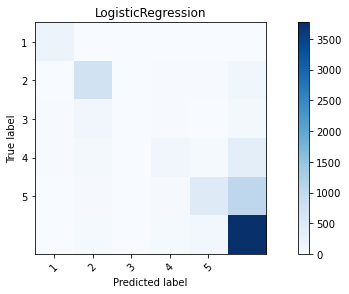

In [331]:
# Create logistic regression confusion matrix.
create_and_print_confusion_matrix(y_test, clf_benchmark.predict(X_test), "LogisticRegression")

<Figure size 432x288 with 0 Axes>

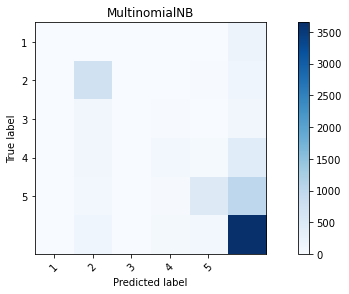

In [332]:
# Create MultinomialNB confusion matrix.
create_and_print_confusion_matrix(y_test, clf_NB_refined.predict(X_test),"MultinomialNB")

<Figure size 432x288 with 0 Axes>

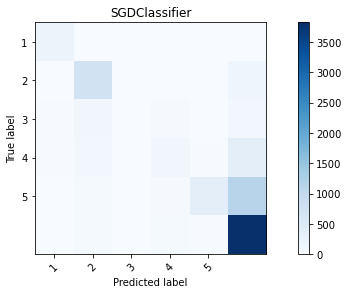

In [353]:
# Create SGDClassifier confusion matrix.
create_and_print_confusion_matrix(y_test, clf_SGD_refined.predict(X_test), "SGDClassifier")

# Word Cloud

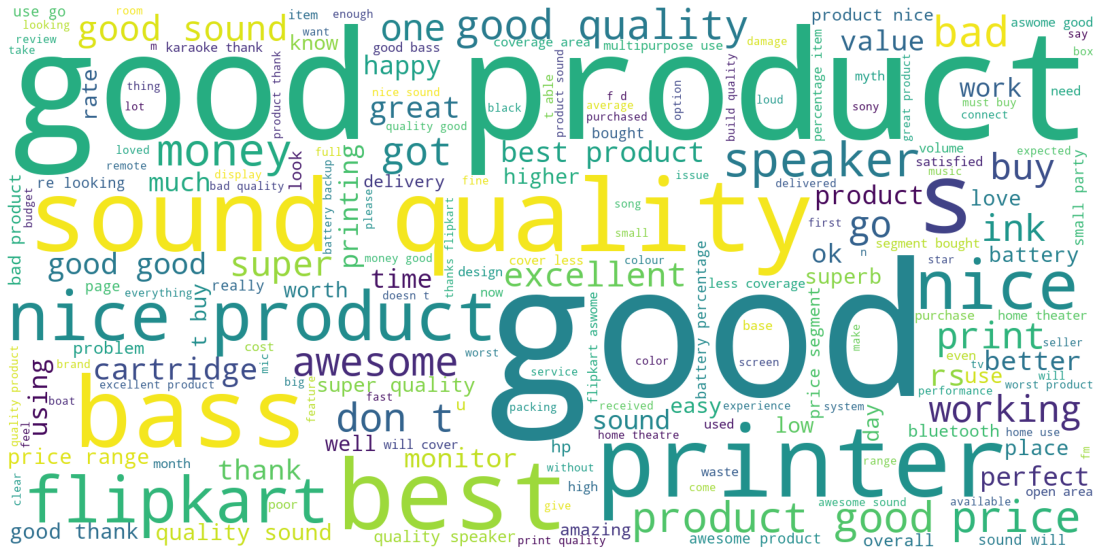

In [334]:
# Create a long string of words.
word_string = ' '.join(reviews)

# Create word cloud using https://github.com/amueller/word_cloud
wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='white',
                      width=1600,
                      height=800
                     ).generate(word_string)

plt.figure( figsize=(20,10), facecolor='white')
plt.imshow(wordcloud)
plt.axis('off')
plt.show()